# 数据分布

In [1]:
import pandas as pd


# 定义自己的数据集
# 使用pandas 连接label下的文件
label_df = pd.read_csv("D:/data/TAL-SER/label/label",sep=" ")
utt2gen_df = pd.read_csv("D:/data/TAL-SER/label/utt2gen",sep=" ",header=None,names=['id','sex'])
utt2spk_df = pd.read_csv("D:/data/TAL-SER/label/utt2spk",sep=" ",header=None,names=['id','speaker'])
wavscp_df = pd.read_csv("D:/data/TAL-SER/label/wavscp",sep=" ",header=None,names=['id','path'])
wavscp_df.sort_values('id', ignore_index=True,inplace =True)
data_df = pd.concat([label_df, utt2spk_df['speaker'], utt2gen_df['sex'],wavscp_df['path']], axis=1)
data_df["path"].replace(".\/S", "D:/data/TAL-SER/S", regex=True,inplace =True)


def function(P, A):
    if  P>0:
        if A>0:
            return 'activate'
        else:
            return 'neutral'
    else:
        if A<0:
            return 'positive'
        else:
            return 'activate'

data_df['emotion'] = data_df.apply(lambda x: function(x.P, x.A), axis = 1)

def function(P, A, sex):
    if  P>0:
        if A>0:
            if sex=='female':
                return 'female_activate'
            else:
                return 'male_activate'
        else:
            if sex=='female':
                return 'female_neutral'
            else:
                return 'male_neutral'
    else:
        if A<0:
            if sex=='female':
                return 'female_positive'
            else:
                return 'male_positive'
        else:
            if sex=='female':
                return 'female_activate'
            else:
                return 'male_activate'

data_df['label'] = data_df.apply(lambda x: function(x.P, x.A,x.sex), axis = 1)
emotions = data_df.emotion.unique()
emotion2idx = dict((emotion,idx) for idx,emotion in enumerate(emotions))
idx2emotion = dict((idx,emotion) for idx,emotion in enumerate(emotions))
print(len(emotions))
data_df['label_idx'] = [emotion2idx[b] for b in data_df.emotion]
data_df.sample(10)


3


,id,P,A,speaker,sex,path,emotion,label,label_idx
2953,4443,0.731495,-1.061525,SER0027,male,D:/data/TAL-SER/SER0027/4443.wav,neutral,male_neutral,0
1186,1755,-1.082984,-0.061173,SER0011,male,D:/data/TAL-SER/SER0011/1755.wav,positive,male_positive,2
2365,3529,-0.046139,0.539038,SER003,female,D:/data/TAL-SER/SER003/3529.wav,activate,female_activate,1
2988,4508,-1.212589,1.039214,SER0010,male,D:/data/TAL-SER/SER0010/4508.wav,activate,male_activate,1
492,703,1.379523,-2.361983,SER0027,male,D:/data/TAL-SER/SER0027/703.wav,neutral,male_neutral,0
2177,3234,0.990706,0.639074,SER009,female,D:/data/TAL-SER/SER009/3234.wav,activate,female_activate,1
4081,6655,0.472284,0.739109,SER0031,female,D:/data/TAL-SER/SER0031/6655.wav,activate,female_activate,1
1025,1517,0.601889,-0.761419,SER0014,female,D:/data/TAL-SER/SER0014/1517.wav,neutral,female_neutral,0
168,256,-1.860617,1.139250,SER0010,male,D:/data/TAL-SER/SER0010/256.wav,activate,male_activate,1
4181,6841,0.861101,-0.461314,SER0014,female,D:/data/TAL-SER/SER0014/6841.wav,neutral,female_neutral,0


In [2]:
data_df.label.value_counts()

female_activate    1780
male_activate      1071
female_neutral      535
male_neutral        468
male_positive       226
female_positive     108
Name: label, dtype: int64

In [3]:
data_df.emotion.value_counts()

activate    2851
neutral     1003
positive     334
Name: emotion, dtype: int64

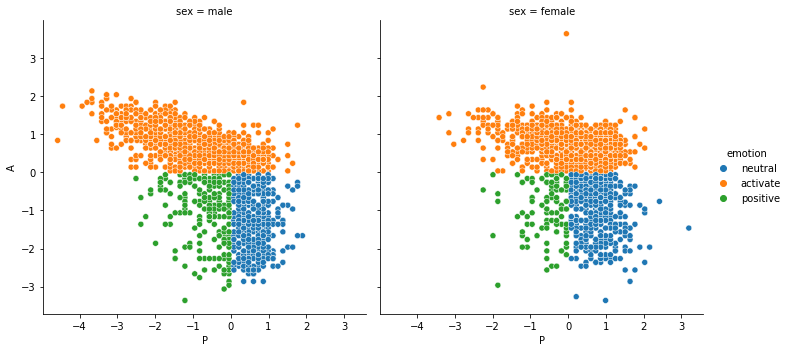

In [4]:
import seaborn as sns
sns.relplot(x="P", y="A", hue="emotion", col="sex", data=data_df);

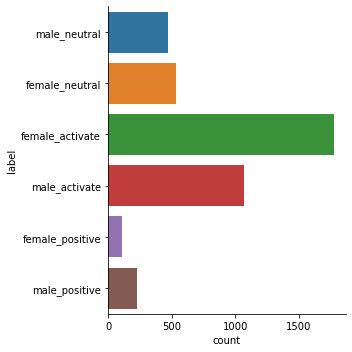

In [5]:
sns.catplot(y="label", kind="count", data=data_df)

In [6]:
# 数据集划分
from sklearn.model_selection import StratifiedShuffleSplit
dataset_names = ['train', 'valid']
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=621)
train_split_idx, val_split_idx = next(iter(stratified_split.split(data_df.id, data_df.emotion)))
train_df = data_df.iloc[train_split_idx].reset_index()
val_df = data_df.iloc[val_split_idx].reset_index()
print(len(train_df))
print(len(val_df))


3769
419


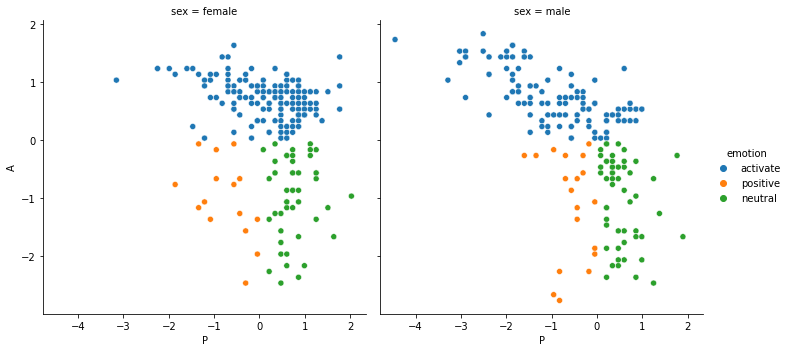

In [7]:
sns.relplot(x="P", y="A", hue="emotion",
            col="sex", data=val_df);

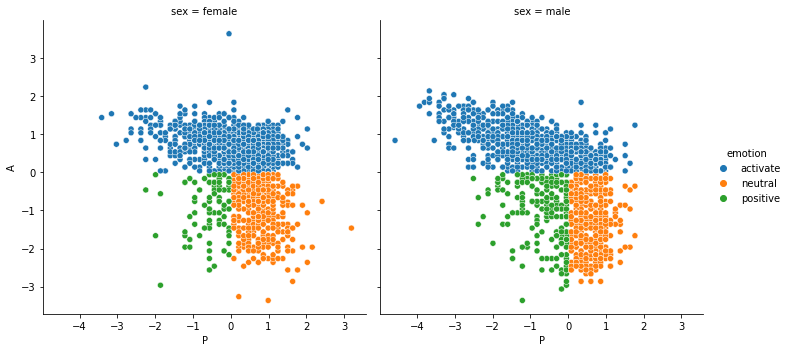

In [8]:
sns.relplot(x="P", y="A", hue="emotion",
            col="sex", data=train_df);

# 数据增强

In [32]:



import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Permute, Multiply
from tensorflow.python.keras.models import Model, load_model
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.layers import Flatten, Conv1D, \
    Activation, BatchNormalization
from tensorflow.keras.layers import LSTM
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import librosa
import numpy as np

In [37]:

    df = pd.DataFrame(columns=['feature'])

    from tqdm.notebook import tqdm
    # loop feature extraction over the entire dataset
    counter=0
    for path in tqdm(data_df.path):
        X, sample_rate = librosa.load(path
                                      , res_type='kaiser_fast'
                                      ,duration=2.5
                                      ,sr=44100
                                      ,offset=0.5
                                     )
        sample_rate = np.array(sample_rate)

        # mean as the feature. Could do min and max etc as well. 
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        df.loc[counter] = [mfccs]
        counter=counter+1   

    # Check a few records to make sure its processed successfully
    print(len(df))
    df.to_csv("feature.csv",index=False)
    df.head()
#     df = pd.concat([data_df,pd.DataFrame(df['feature'].values.tolist())],axis=1)
#     df[:5]

  0%|          | 0/4188 [00:00<?, ?it/s]

4188


,feature
0,"[-7.752596, -5.4398274, -1.7515907, 0.40127915..."
1,"[-12.416408, -12.905608, -12.362558, -11.52998..."
2,"[-10.248148, -8.753417, -10.574772, -11.975676..."
3,"[-9.437909, -9.425036, -10.350374, -11.193178,..."
4,"[-9.23068, -6.648475, -6.88263, -6.453015, -5...."


In [11]:
# # 添加噪声版提取mfcc
# try:
#   df=pd.read_csv("feature_with_noise.csv")
#     df = pd.concat([data_df,pd.DataFrame(df['feature'].values.tolist())],axis=1)
#     df[:5]
# except:    
#     df = pd.DataFrame(columns=['feature'])
#     df_noise = pd.DataFrame(columns=['feature'])
#     df_speedpitch = pd.DataFrame(columns=['feature'])
#     cnt = 0

#     # loop feature extraction over the entire dataset
#     for i in tqdm(ref.path):

#         # first load the audio 
#         X, sample_rate = librosa.load(i
#                                       , res_type='kaiser_fast'
#                                       ,duration=2.5
#                                       ,sr=44100
#                                       ,offset=0.5
#                                      )

#         # take mfcc and mean as the feature. Could do min and max etc as well. 
#         mfccs = np.mean(librosa.feature.mfcc(y=X, 
#                                             sr=np.array(sample_rate), 
#                                             n_mfcc=13),
#                         axis=0)

#         df.loc[cnt] = [mfccs]   

#         # random shifting (omit for now)
#         # Stretch
#         # pitch (omit for now)
#         # dyn change

#         # noise 
#         aug = noise(X)
#         aug = np.mean(librosa.feature.mfcc(y=aug, 
#                                         sr=np.array(sample_rate), 
#                                         n_mfcc=13),    
#                       axis=0)
#         df_noise.loc[cnt] = [aug]

#         # speed pitch
#         aug = speedNpitch(X)
#         aug = np.mean(librosa.feature.mfcc(y=aug, 
#                                         sr=np.array(sample_rate), 
#                                         n_mfcc=13),    
#                       axis=0)
#         df_speedpitch.loc[cnt] = [aug]   

#         cnt += 1

#     df.head()
#     df = pd.concat([data_df,pd.DataFrame(df['feature'].values.tolist())],axis=1)
#     df[:5]

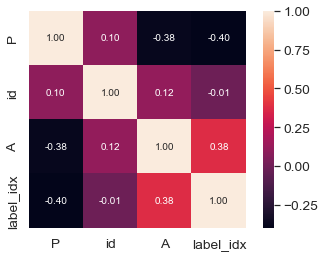

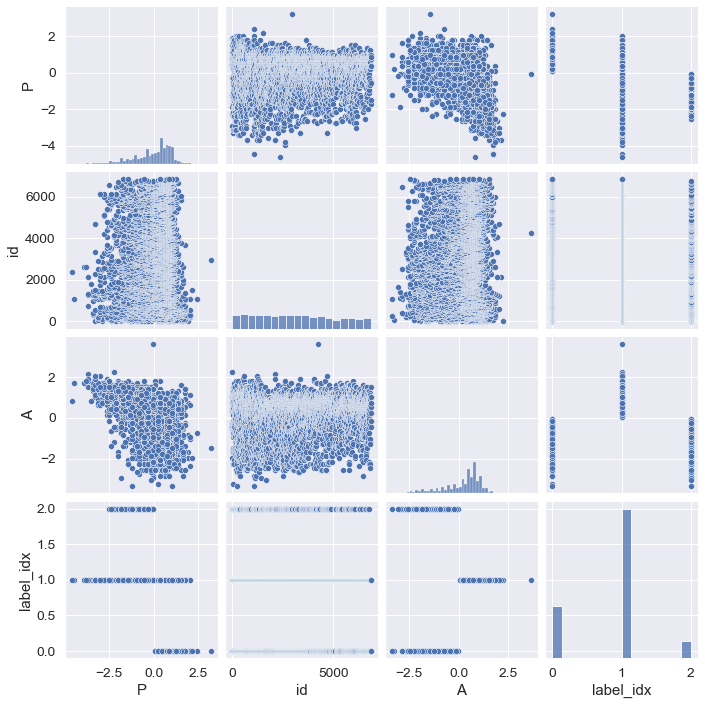

In [34]:
import seaborn as sns
k=10
corrmat = df.corr()
cols = corrmat.nlargest(k, 'P')['P'].index # P column name
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

sns.pairplot(df[cols])

In [30]:
X = df.iloc[: ,9:].values
Y = df['emotion'].values
X.shape,Y

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

from sklearn.model_selection import train_test_split
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape



# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape



KeyError: 'emotion'

In [26]:
 def cnn3(x_train, y_train):
    # New model
    model = Sequential()
    model.add(Conv1D(256, 5, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    model.add(Activation('relu'))
    model.add(Conv1D(256, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1])) # Target class number
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    model.summary()
    plot_model(model=model, to_file='model_cnn3.png',shaow_spades=True)
    return model

In [ ]:
def cnn2(x_train, y_train):
    model = Sequential()
    model.add(Conv1D(256, 5, padding='same', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    model.add(Activation('relu'))
    model.add(Conv1D(256, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1])) # Target class number
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [ ]:

def lstm(x_train, y_trai):
    model=Sequential()
    model.add(LSTM(input_spade=x_train.shape[1],1),output_dim=x_train.shape[1],return_sequences=True)
    return model

In [ ]:


def attention_block(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(1, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


def cnn_lstm(x_train,y_train):
    model = Sequential()
    input = Input([1, x_train.shape[1]])
    x = Conv1D(filters=128, kernel_size=5, padding='same')(input)  # 卷积层
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128, kernel_size=5, padding='same')(x)  # 卷积层
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    # x = attention_block(x)
    x = LSTM(128, return_sequences=True)(x)  # (time_steps = 1, n_feats)
    x = attention_block(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    # x = Dense(rnn_size, activation='tanh')(x)

    x = Dense(y_train.shape[1], activation='softmax')(x)  # 分类层
    model.add(Model(input, x))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

model=cnn3(x_train,y_train)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node max_pooling1d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 5, 1, 1], padding="VALID", strides=[1, 5, 1, 1]](max_pooling1d/ExpandDims)' with input shapes: [?,1,1,256].

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
TP_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
TP_df['Predicted Labels'] = y_pred.flatten()
TP_df['Actual Labels'] = y_test.flatten()

TP_df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)